# 결정 트리

## 6.1 결정 트리 학습과 시각화

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

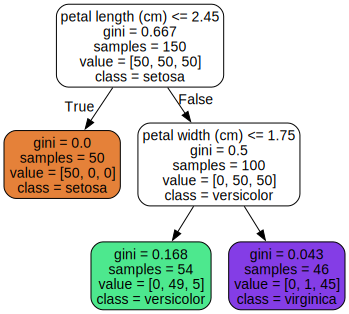

In [8]:
import graphviz
with open("iris_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

- 결정 트리는 데이터 전처리가 거의 필요하지 않음  
- 특히 특성의 스케일을 맞추거나 평균을 원점에 맞추는 작업이 필요하지 않음  

## 6.2 예측하기

노드
- gini 속성: 불순도를 측정  
한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드는 순수하다 (gini=0)
- sample 속성: 얼마나 많은 훈련 샘플이 적용되었는지  
- value 속성: 각 클래스에 얼마나 많은 훈련 샘플이 있는지  

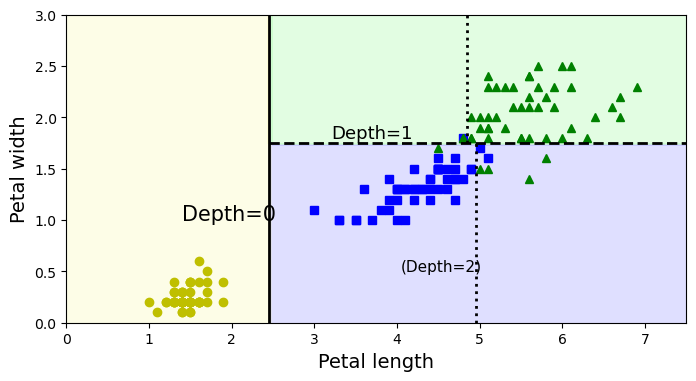

In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_boundary(
    clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(["#7d7d58", "#4c4c7f", "#507d50"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

모델 해석: 화이트박스와 블랙박스  
- **화이트박스** 모델: 매우 직관적이고 **결정 방식을 이해하기 쉬운**(명확한 분류 방법을 사용하는) 결정 트리와 같은 모델  
- **블랙박스** 모델: 연산 과정을 쉽게 확인할 수 있으나 **왜 그런 예측을 만드는지는 쉽게 설명하기 어려운** 랜덤 포레스트, 신경망과 같은 모델  

## 6.3 클래스 확률 추정

In [16]:
# 길이가 5cm이고 너비가 1.5cm인 꽃잎
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [17]:
# Iris-Versicolor (class 1)
tree_clf.predict([[5, 1.5]])

array([1])

## 6.4 CART 훈련 알고리즘

CART 알고리즘  
1. 훈련 세트를 하나의 특성 $k$의 임곗값 $t_k$를 사용해 두 개의 부분 집합으로 나눔  
이때 가장 순수한 부분 집합으로 나눌 수 있는(CART 비용 함수를 최소화하는) ($k$, $t_k$)를 찾음  
2. 같은 방식으로 부분 집합을 반복하여 분할함  
3. 최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 종료  

- CART 알고리즘은 Greedy하다(최적해 보장 X)
- 최적의 트리를 찾는 것은 NP-Complete 문제이다. ($O(exp(m))$의 시간복잡도)

## 6.5 계산 복잡도

예측: 각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관하게 $O(log_2(m))$  
훈련: 각 노드에서 모든 훈련 샘플의 모든 특성을 비교하기에 $O(n \times mlog(m))$  
- 훈련 세트가 (수천 개 이하 샘플 정도) 작을 경우 사이킷런에서 `presort=True`로 지정하여 미리 데이터를 정렬하여 훈련 속도를 높일 수 있음 (훈련 세트가 클 경우 많이 느려짐)  

## 6.6 지니 불순도 또는 엔트로피?

#### 엔트로피
- 분자의 무질서함을 측정, 엔트로피가 0이면 안정되고 질서 정연한 상태.    
#### 정보 이론
- 모든 메세지가 동일할 때 엔트로피가 0.  
- 엔트로피 감소량을 정보 이득(information gain)이라고도 함. 노드가 순수해진 정도를 뜻함.  
#### 지니 불순도 VS 엔트로피
- 큰 차이가 없음.  
- 지니 불순도가 조금 더 계산이 빠름.  
- 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반면 엔트로피는 조금 더 균형 잡힌 트리를 만듦.

## 6.7 규제 매개변수

**비 파라미터 모델**: 훈련되기 전에 파라미터 수가 결정되지 않음 (e.g. 결정 트리)  
- 제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고 해서 과대적합되기 쉬움.  

**파라미터 모델**: 미리 정의된 모델 파라미터 수를 가짐 (e.g. 선형 모델)  
- 자유도가 제한되고 과대적합될 위험이 줄어듦. 대신 과소적합될 위험은 커짐.  

**규제**  
- min_samples_split (분할되기 위해 노드가 가져야 하는 최소 샘플 수)    
- min_samples_leaf (리프 노드가 가지고 있어야 할 최소 샘플 수)  
- max_leaf_nodes (리프 노드의 최대 수)  
- max_features (각 노드에서 분할에 사용할 특성의 최대 수)  

#### 가지치기
- 제한 없이 결정 트리를 훈련시키고 불필요한 노드를 제거하느 알고리즘  
- 순도를 높이는 것이 **통계적으로 큰 효과가 없다면** 리프 노드 바로 위의 노드는 불필요할 수 있음.  
- **$x^2$검정** 같은 통계적 검정을 사용하여 우연히 향상된 것인지 추정(**귀무가설**)  
- 이 확률을 $p-value$라 부르며 어떤 임곗값(통상적으로 5%)보다 높으면 불필요한 노드로 간주되고 그 자식 노드는 삭제됨.  

## 6.8 회귀

In [21]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X,y)

DecisionTreeRegressor(max_depth=2)

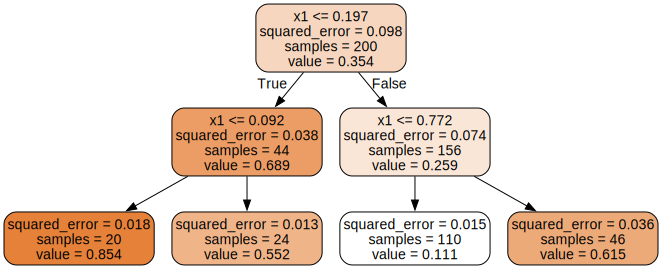

In [23]:
export_graphviz(
    tree_reg,
    out_file="tree_reg.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True,
)

with open("tree_reg.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

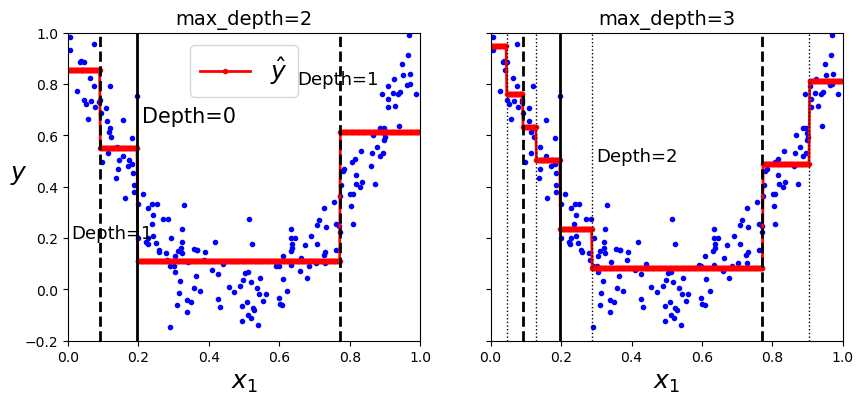

In [24]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)


def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

## 6.9 불안정성

- 쉽고, 사용하기 편하고, 여러 용도로 사용할 수 있으며, 성능도 뛰어남.  
- 결정 트리는 계단 모양의 결정 경계(모든 분할은 축에 수직)를 만들기 때문에 훈련 세트의 회전에 민감함 -> PCA 기법을 사용  
- 훈련 데이터에 있는 작은 변화에도 매우 민감함 -> 랜덤 포레스트 사용  

## 6.10 연습문제

#### 1. 백만 개의 샘플을 가진 훈련 세트에서 (규제 없이) 훈련시킨 결정 트리의 깊이는 대략 얼 마일까요?

#### 2. 한 노드의 지니 불순도가 보통 그 부모 노드보다 작을까요, 아니면 클까요? 일반적으로 작 거나 클까요, 아니면 항상 작거나 클까요?

#### 3. 결정 트리가 훈련 세트에 과대적합되었다면 max_depth를 줄이는 것이 좋을까요?

#### 4. 결정 트리가 훈련 세트에 과소적합되었다면 입력 특성의 스케일을 조정하는 것이 좋을까요?

#### 5. 백만 개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데 한 시간이 걸렸다면, 천만 개의 샘플을 가진 훈련 세트에 결정 트리를 훈련시키는 데는 대략 얼마나 걸릴까요?

#### 6. 십만 개의 샘플을 가진 훈련 세트가 있다면 presort=True로 지정하는 것이 훈련 속도를 높일까요?

#### 7. moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요.
1. make_moons (n_Samples=1000, noise=0.4)를 사용해 데이터셋을 생성합니다.  
2. 이를 train_test_split()을 사용해 훈련 세트와 테스트 세트로 나눕니다.  
3. DecisionTreeClassifier의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다(GridSearchcV를 사용하면 됩니다). 힌트: 여러 가지 max_leaf_nodes 값을 시도해보세요.  
4. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.  

#### 8. 랜덤 포레스트를 만들어보세요.
1. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1.000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다. 힌트: 사이킷런의 Shufflesplit을 사용할 수 있습니다.  
2. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킵니다. 테스트 세트로 이 1,000개의 결정 트리를 평가합니다. 더 작은 데이터셋에서 훈련되었기 때문 에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약 80%의 정확도를 냅니다.  
3. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측 을 만들고 다수로 나온 예측만 취합니다(사이파이의 mode()함수를 사용할 수 있습니다). 그러면 테스트 세트에 대한 다수결 예측(majority-Vote prediction)이 만들어집니다.  
4. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은 (약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!  